# Loan defaults prediction using Sparkling Water

## Outline:

- Architecture
    - environment set-up:
        - `Pipenv`
        - `Spark`
        - `Jupyter`
        - `H2O`
    - how to run this notebook
- Set-up datasets using local spark warehouse
- `Spark:` Initial data exploration
    - target variable distribution
    - first hypotheses
    - data pre-processing
    - heavy feature engineering (leveraging Spark)
        - averages using window functions
        - removing non-significant keywords
    - data cleaning (simple operations that can be done in Spark)
- `H2O:`
    - variable encoding
    - outlier detection
    - leveraging `scikit-learn` for small scale pre-processing
    - set-up baseline model
        - mean model
    - develop more complex models (tracking performance with baseline to find the value of development)
- Summary
    - use AWS EC2 for reproducible and scalable model building
        - we might at some point try to use a cluster of machines for that
    - export **user settings** for the notebook
    - **create functions** from code that will be reused more than once
    - two stage models do not really work! (unless first level is very, very accurate)
    - Always use simpler model from the very beginning that will open the road to smart feature engineering
        - average rev per campaign
        - avreage rev per account etcc
    - All in all sampling and weighting can make a process much faste
    - Balancing is a good idea but not in two step models (too much to be done in the end)
    - Workflow with Sparkling water is very robust and enables to leverage a lot of Python libraries (scikit-learn, scipy)
    - deep learning is not super fast (even on fast machine) so for big datasets like this one would probably still use XGboost




## How to run this notebook on Amazon EC2 cluster:

 - clone the repo
 - run installation script
 - start jupyter notebook server
 - load the notebook
 - export Python envir for Spark
 - export AWS credentials for S3 bucket

## Architecture details:

![alt text](https://i0.wp.com/blog.h2o.ai/wp-content/uploads/2017/04/hdi-image5.jpg?resize=700%2C394)

Note: also using `scikit-learn` utilities are much easier with H2O Data Frame than with pySpark (due to the unordered character of Spark DataFrame)

As a master node I'm using AWS `t2.x2large` instance with following specs:

In [1]:
!sudo lshw -short

H/W path    Device  Class      Description
                    system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/405              processor  CPU
/0/406              processor  CPU
/0/407              processor  CPU
/0/408              processor  CPU
/0/1000             memory     32GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/1000/1           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3            generic    Xen Platform Device
/1          eth0    network  

## Task description:

#### Advertiser programatic bidding:

 - The advertiser can set a price for each keyword/match type combination. 
 - She can even refine her price setting by taking the device (computer, mobile, ...) into account. 
 - She is furthermore free to update the prices whenever she wants. 

The set price mainly determines if her advertisement is shown to the user instead of a competitor’s one. Although the price decides on if the advertisement is shown, the advertiser only has to pay if the user clicks on the advertisement. A click redirects the user to the advertiser’s website offering him products that match what she was searching for. All the money the particular user spends in the next days on the advertiser’s website is attributed to the click, i.e. it is assumed that all the revenue the user generated with her conversions (=bookings, orders) after clicking on the advertisement was triggered by the advertisement.

#### Keyword taxonomy:

An online platform such as GetYourGuide provides easily thousands of products. Each product can have several relevant keywords such that the number of managed keywords is immense. Therefore, a hierarchy helps to categorize keywords:

 - **Keywords** belonging to the same product **are collected in an ad group**. 
 - Several ad groups can contain the same keyword, the combination of keyword and ad group is then again unique. 
 - **Ad groups** with a similar scope are bundled **in a campaign**. 
 - **Campaigns** for a common target audience are collected **in the same account**.

#### The question:

A crucial question to answer when pricing the keywords is how much revenue one can expect from a click. In other words, what is the expected Revenue per Click (RPC). Answering this question is your task in this test.

#### Evaluation metrics:

Click weighted squared distance:

$$ cost = \frac{1}{C} \sum_{i=1}^{N} \left[ c_n(r_n - \hat{r_n})^2 \right] $$

This means that we can drop all rows from dataset where number of click was zero...

-----

### Model training assumptions
 
- for now fit the models within channels from single periodicity tables
- we might have models fit depending on coverage for other categories
- no weighting/resmpling of outlets (we assume that within segments store pool is representative)
- we tune regularisation parameters using k-fold cross validation
- static model with time effects for some variables (also tested whether it improves model)
- automatic detection of the features to be sumplemented with time dependency
- we filter the data so it cover 95% of sales from items that we have seen product lifecycle from their very begining
- we create table with launch dates within segments (to be replaced by separate Spark Job)
- products doesn't have to end their plc, we will use normalized plc to discount achieved level of weighted distribution
- create table with estimated product distribution
- 2010 - 2017 (8 years)
- create table with imputed prices (linear imputation)
- no test if fit is close to cross-validation results
- for now all items (we can aggregate long-tails later)
- h2o model with Poisson multinomial trick as a benchmark for Michael pyTorch implementation

## User specified parameters

- `usr_fact_table: String` - name of the table with facts
- `usr_item_keys: Array[String]` - name of the variables identifying stock-keeping unit (SKU)
- `usr_item_table: String` - name of the table with imputed product features
- `usr_launch_buffer: Int` - number of days that has to elapse since the begining of data to call first sales a launch

In [2]:
usr_s3_data_path = 's3n://jakubs-bucket/club_loan/loan.csv'
usr_min_recall = .90

## Setting data access

 - Loan csv file was loaded into the Amazon Simple Storage Service (S3) serving as a primary source of data and back-up
 - to speed up process of loading data into Spark DataFrame we loaded the data into local metastore

In [3]:
!tree /home/ubuntu/spark-warehouse/

/home/ubuntu/spark-warehouse/
└── loan.db
    └── data
        ├── part-00000-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00001-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00002-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00003-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00004-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00005-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00006-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00007-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        └── _SUCCESS

2 directories, 9 files


## Data cleaning and feature engineering

In [41]:
sdf_loan = spark \
    .sql('select * from loan.data') \
    .persist()
    
sdf_loan.count()

887379

In [42]:
from pyspark.sql.functions import udf, sum, col, when
 
# TODO: move to functions and add doc-string
def count_null_values(df):
    cols = df.schema.names
    cols = df.schema.names
    expr = [sum(when(col(name).isNull(), 1).otherwise(0)).alias(name) for name in cols]
    
    return df.agg(*expr).toPandas()   

In [43]:
def filter_and_cast(var, ctype, sdf):
    res = sdf \
        .withColumn(var, col(var).cast(ctype)) \
        .filter(col(var).isNull() == False)
    n1 = res.count()
    n = sdf.count()
    
    print('Filtering and casting {}: removed {n} ({p:2.3f}%) cases due to the missing info '
          .format(var, n=n-n1, p=(1-n1/n)* 100))
    return res

In [44]:
from pyspark.sql.functions import udf, month, year
from pyspark.sql.types import DateType, datetime
import re

@udf(returnType=DateType())
def udf_extract_date(x):
    
    year = int(re.search('(?<=-)\w+', x).group(0))
    return datetime.date(year, 1, 1)

In [45]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# generator function based on passed dictionary
def udf_recode_string(d):
    
    def recode(x):
        if x in d.keys():
            return d[x]
        else:
            return None
    return udf(recode, returnType=StringType())

### Target variable (Loan status) preparation

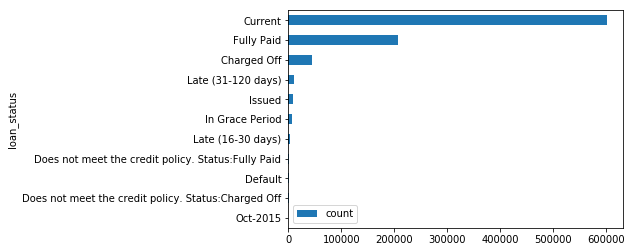

In [46]:
tmp = sdf_loan.select('loan_status').groupBy('loan_status').count().orderBy('count').toPandas()
tmp = tmp.set_index('loan_status')
tmp.plot.barh()

In [47]:
loan_status_dict = {}
loan_status_dict['Does not meet the credit policy. Status:Charged Off'] = 'Default'
loan_status_dict['Default'] = 'Default'
loan_status_dict['Does not meet the credit policy. Status:Fully Paid'] = 'Fully Paid'
loan_status_dict['Late (16-30 days)'] = 'Current'
loan_status_dict['In Grace Period'] = 'Current'
loan_status_dict['Late (31-120 days)'] = 'Default'
loan_status_dict['Charged Off'] = 'Default'
loan_status_dict['Fully Paid'] = 'Fully Paid'
loan_status_dict['Current'] = 'Current'
loan_status_dict['Issued'] = None
loan_status_dict['Oct-2015'] = None

sdf_loan_clean = sdf_loan \
        .withColumn('loan_status', udf_recode_string(loan_status_dict)(col('loan_status'))) \
        .withColumn('loan_default', (col('loan_status') == 'Default').cast('int')) \

# remove observations with unclear data
sdf_loan_clean = filter_and_cast('loan_status', 'string', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('loan_default', 'int', sdf_loan_clean)

Filtering and casting loan_status: removed 8461 (0.953%) cases due to the missing info 
Filtering and casting loan_default: removed 0 (0.000%) cases due to the missing info 


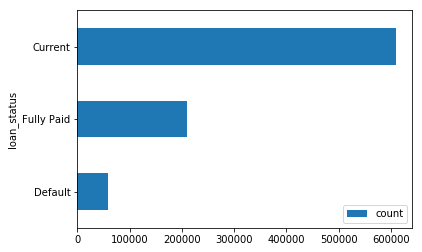

In [48]:
tmp = sdf_loan_clean.select('loan_status').groupBy('loan_status').count().orderBy('count').toPandas()
tmp = tmp.set_index('loan_status')
tmp.plot.barh()

### Loan variables preparation (here just summary of actions done)

- cast numeric variables to float
- filter cases with missing values
- cast variables to numeric
- cast date variables to datetime format
- extract year and month from issue_d (not to be used in models though, see notes below)
- `total_exp_pymnt` amount expected to be paid off
- percentage of debt paid (to calculate ROI)

In [49]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, max, lit, datediff, add_months
from pyspark.sql import Window

w_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [100]:
sdf_loan_clean.groupBy('grade', 'sub_grade').count().orderBy(col('count').desc()).toPandas().head()

,grade,sub_grade,count
0,B,B3,55752
1,B,B4,55083
2,C,C1,52785
3,C,C2,51711
4,C,C3,49668


In [102]:
# variables describing loan itself
from pyspark.sql.functions import unix_timestamp, year, month, from_unixtime

var_descr_loan = ['issue_d', 
            'issue_d_year',
            'issue_d_month',
            'loan_amnt',
            'total_amnt_due',
            'int_rate',
            'installment',
            'term', 
            'term_n',
            'total_pymnt',
            'total_rec_prncp',
            'total_rec_prncp_perc',
            'out_prncp',
            'time_covered_prc'
                 ]

# filter null values and cast to appropriate types
sdf_loan_clean = filter_and_cast('total_pymnt', 'double', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('total_rec_prncp', 'double', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('out_prncp', 'double', sdf_loan_clean)

# create Spark dateteime object from issue_d
sdf_loan_clean = sdf_loan_clean \
        .withColumn('issue_d_ts', from_unixtime(unix_timestamp(col('issue_d'), format='MMM-yyyy'))) \
        .withColumn('issue_d_year', year(col('issue_d_ts'))) \
        .withColumn('issue_d_month', month(col('issue_d_ts')))
        
# create number of installments
sdf_loan_clean = sdf_loan_clean \
        .withColumn('term_n', when(col('term') == ' 36 months', lit(36.0)).otherwise(60))

# create total ammount due
sdf_loan_clean = sdf_loan_clean \
        .withColumn('total_amnt_due', col('term_n') * col('installment'))

# create percentage of the timeline covered by the data
max_issue_d = sdf_loan_clean.select('issue_d_ts').agg(max(col('issue_d_ts')).alias('m')).collect()
max_issue_d = max_issue_d[0]['m']

sdf_loan_clean = sdf_loan_clean \
    .withColumn('issue_d_ts_max', lit(max_issue_d)) \
    .withColumn('time_covered', datediff(col('issue_d_ts_max'), col('issue_d_ts'))) \
    .withColumn('time_to_payoff', col('term_n') * 30) \
    .withColumn('time_covered_prc', when(col('time_covered') / col('time_to_payoff') < 1.0,
                                        col('time_covered') / col('time_to_payoff')).otherwise(1.0)) \

# create percentage of debt paid
sdf_loan_clean = sdf_loan_clean \
        .withColumn('total_rec_prncp_perc', col('total_rec_prncp') / col('loan_amnt'))
    
    
# grade and subgrade
sdf_loan_clean = filter_and_cast('grade', 'string', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('sub_grade', 'string', sdf_loan_clean)

Filtering and casting total_pymnt: removed 0 (0.000%) cases due to the missing info 
Filtering and casting total_rec_prncp: removed 0 (0.000%) cases due to the missing info 
Filtering and casting out_prncp: removed 0 (0.000%) cases due to the missing info 
Filtering and casting grade: removed 0 (0.000%) cases due to the missing info 
Filtering and casting sub_grade: removed 0 (0.000%) cases due to the missing info 


#### Quality checks

In [51]:
tmp = sdf_loan_clean.select(*var_descr_loan)

# check types and amount of missings
tmp.printSchema()
count_null_values(tmp)

root
 |-- issue_d: string (nullable = true)
 |-- issue_d_year: integer (nullable = true)
 |-- issue_d_month: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- total_amnt_due: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- term: string (nullable = true)
 |-- term_n: double (nullable = false)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_prncp_perc: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- time_covered_prc: double (nullable = true)



,issue_d,issue_d_year,issue_d_month,loan_amnt,total_amnt_due,int_rate,installment,term,term_n,total_pymnt,total_rec_prncp,total_rec_prncp_perc,out_prncp,time_covered_prc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
sdf_loan_clean.persist()
sdf_loan_clean.count()

878750

### Loan description variables
 - title
 - user comments

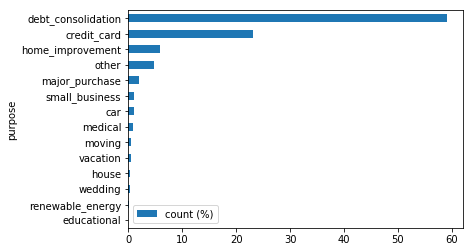

In [54]:
# frequency analysis of 'purpose'
import numpy as np

tmp = sdf_loan_clean.groupBy('purpose').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])
tmp = tmp.loc[tmp['count'] > 1, ].set_index('purpose')
tmp[['count (%)']].sort_values('count (%)', ascending=True).plot.barh()

In [55]:
# keep only texts with count > 1
loan_purpose_dict = {}
for lev in tmp.index.values:
    loan_purpose_dict[lev] = lev

sdf_loan_clean = sdf_loan_clean \
        .withColumn('purpose', udf_recode_string(loan_purpose_dict)(col('purpose')))
sdf_loan_clean = filter_and_cast('purpose', 'string', sdf_loan_clean)

Filtering and casting purpose: removed 86 (0.010%) cases due to the missing info 


### Generate key-words and 2-grams for title field

https://en.wikipedia.org/wiki/N-gram

In [56]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, VectorAssembler

# remove records with null title value
sdf_loan_clean = filter_and_cast('title', 'string', sdf_loan_clean)

# split tile into words
tmp_tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
sdf_loan_clean = tmp_tokenizer.transform(sdf_loan_clean)

# remove English stop words
tmp_remover = StopWordsRemover(inputCol="title_tokens",
                               outputCol="title_words",
                               stopWords=StopWordsRemover.loadDefaultStopWords('english'))
sdf_loan_clean = tmp_remover.transform(sdf_loan_clean)

# create n-grams
tmp_ngram = NGram(n=2, inputCol="title_words", outputCol="title_ngrams")
sdf_loan_clean = tmp_ngram.transform(sdf_loan_clean)



Filtering and casting title: removed 34 (0.004%) cases due to the missing info 


In [65]:
sdf_loan_clean = sdf_loan_clean.drop('title_words_vec')
sdf_loan_clean = sdf_loan_clean.drop('title_ngrams_vec')

In [66]:
# create binary representation
cv = CountVectorizer(inputCol="title_words", 
                     outputCol="title_words_vec", 
                     binary=True,
                     minDF=.001)

cv_fit = cv.fit(sdf_loan_clean)

sdf_loan_clean = cv_fit.transform(sdf_loan_clean).persist()
sdf_loan_clean.count()

878630

In [67]:
# create binary representation
cv = CountVectorizer(inputCol="title_ngrams", 
                     outputCol="title_ngrams_vec", 
                     binary=True,
                     minDF=.001)

cv_fit = cv.fit(sdf_loan_clean)

sdf_loan_clean = cv_fit.transform(sdf_loan_clean).persist()
sdf_loan_clean.count()

878630

In [68]:
sdf_loan_clean.select('title_words_vec', 'title_ngrams_vec').show(truncate=False)

+----------------------------+--------------------+
|title_words_vec             |title_ngrams_vec    |
+----------------------------+--------------------+
|(50,[],[])                  |(25,[],[])          |
|(50,[],[])                  |(25,[],[])          |
|(50,[10],[1.0])             |(25,[],[])          |
|(50,[],[])                  |(25,[],[])          |
|(50,[16],[1.0])             |(25,[],[])          |
|(50,[7,12,28],[1.0,1.0,1.0])|(25,[],[])          |
|(50,[7],[1.0])              |(25,[],[])          |
|(50,[15],[1.0])             |(25,[],[])          |
|(50,[1,10,47],[1.0,1.0,1.0])|(25,[],[])          |
|(50,[2],[1.0])              |(25,[],[])          |
|(50,[0,37],[1.0,1.0])       |(25,[],[])          |
|(50,[0],[1.0])              |(25,[],[])          |
|(50,[26],[1.0])             |(25,[],[])          |
|(50,[],[])                  |(25,[],[])          |
|(50,[7],[1.0])              |(25,[],[])          |
|(50,[0,1,7],[1.0,1.0,1.0])  |(25,[0,5],[1.0,1.0])|
|(50,[5],[1.

In [69]:
# frequency analysis of 'title'

tmp = sdf_loan_clean.groupBy('title').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])

print(len(tmp.loc[tmp['count (cum %)'] < 95, 'count']))
tmp.head()

19026


,title,count,count (%),count (cum %)
0,Debt consolidation,409265,46.579903,46.579903
1,Credit card refinancing,162289,18.470687,65.050590
2,Home improvement,39631,4.510545,69.561135
3,Other,31422,3.576249,73.137384
4,Debt Consolidation,15757,1.793360,74.930744


In [200]:
# frequency analysis of nulls for desc?

## Modeling

### Sample composition

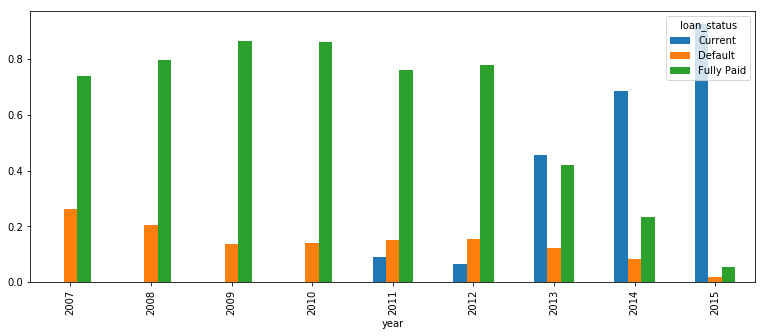

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tmp = sdf_loan_clean \
    .select('loan_status', col('issue_d_year').alias('year')) \
    .groupBy('loan_status', 'year').count() \
    .orderBy(col('count').asc()) \
    .toPandas()
    
def tmp_lambda(x):
    x[np.isnan(x)] = 0.0
    x = x / x.sum()
    return x
    
tmp \
    .pivot(index='year', columns='loan_status', values='count') \
    .apply(tmp_lambda, axis=1) \
    .plot.bar(figsize=(13, 5))

TODO: bias in number of loans... (number of loans and amount of money per year)  
TODO: total structure of the classes

#### Conclusions:

 - we cannot use date as this would simply reflect the loan structure

### Book ROI

In [71]:
tmp = sdf_loan_clean \
        .withColumn('loan_amnt', 
                    when(col('loan_status') == 'Current', col('total_rec_prncp')).otherwise(col('loan_amnt'))) \
        .select('loan_default', 'total_pymnt', 'loan_amnt', 'issue_d_year') \
        .groupBy('issue_d_year') \
        .agg(sum(col('loan_amnt')).alias('loan_amnt'), sum(col('total_pymnt')).alias('total_pymnt')) \
        .toPandas()

tmp['REVENUE'] = tmp['total_pymnt']  / 1e6       
tmp['PROFIT'] = (tmp['total_pymnt'] - tmp['loan_amnt']) / 1e6
tmp['ROI'] = tmp['total_pymnt'] / tmp['loan_amnt'] - 1.0

tmp.sort_values('issue_d_year', ascending=True)

,issue_d_year,loan_amnt,total_pymnt,REVENUE,PROFIT,ROI
0,2007,4.970300e+06,4.716641e+06,4.716641,-0.253659,-0.051035
8,2008,2.073080e+07,1.995242e+07,19.952424,-0.778376,-0.037547
5,2009,5.065520e+07,5.456492e+07,54.564924,3.909724,0.077183
6,2010,1.307162e+08,1.394485e+08,139.448501,8.732315,0.066804
7,2011,2.553960e+08,2.835202e+08,283.520239,28.124230,0.110120
4,2012,6.876583e+08,7.728441e+08,772.844089,85.185791,0.123878
2,2013,1.626120e+09,1.875183e+09,1875.182561,249.062767,0.153164
3,2014,1.917261e+09,2.227741e+09,2227.741103,310.480481,0.161940
1,2015,1.088727e+09,1.326212e+09,1326.212190,237.485223,0.218131


In [72]:
tmp = sdf_loan_clean \
        .filter(col('loan_status') != 'Current') \
        .select('loan_default', 'total_pymnt', 'loan_amnt', 'issue_d_year') \
        .groupBy('issue_d_year') \
        .agg(sum(col('loan_amnt')).alias('loan_amnt'), sum(col('total_pymnt')).alias('total_pymnt')) \
        .toPandas()

tmp['REVENUE'] = tmp['total_pymnt']  / 1e6       
tmp['PROFIT'] = (tmp['total_pymnt'] - tmp['loan_amnt']) / 1e6
tmp['ROI'] = tmp['total_pymnt'] / tmp['loan_amnt'] - 1.0

tmp.sort_values('issue_d_year', ascending=True)

,issue_d_year,loan_amnt,total_pymnt,REVENUE,PROFIT,ROI
0,2007,4.970300e+06,4.716641e+06,4.716641,-0.253659,-0.051035
8,2008,2.073080e+07,1.995242e+07,19.952424,-0.778376,-0.037547
5,2009,5.065520e+07,5.456492e+07,54.564924,3.909724,0.077183
6,2010,1.306300e+08,1.393281e+08,139.328097,8.698147,0.066586
7,2011,2.293101e+08,2.441772e+08,244.177160,14.867035,0.064834
4,2012,6.448179e+08,6.970534e+08,697.053381,52.235506,0.081008
2,2013,1.057072e+09,1.066971e+09,1066.971203,9.899703,0.009365
3,2014,1.061570e+09,9.552547e+08,955.254662,-106.315063,-0.100149
1,2015,4.520362e+08,3.633159e+08,363.315934,-88.720216,-0.196268


### Balance classes

In [73]:
from pyspark.sql.functions import lit, when

sdf_loan_clean = sdf_loan_clean.withColumn('w', lit(1.0))

tmp_0 = sdf_loan_clean.filter(col('loan_default') == 0).agg(sum(col('w')).alias('w')).collect()[0].w
tmp_1 = sdf_loan_clean.filter(col('loan_default') == 1).agg(sum(col('w')).alias('w')).collect()[0].w
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage before weighting: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

# class weights
N = tmp_0 + tmp_1
w_0 = N * .5 / tmp_0
w_1 = N * .5 / tmp_1

# create weight column
sdf_loan_clean = sdf_loan_clean \
            .withColumn('w', when(col('loan_default') == 1, col('w') * w_1).otherwise(col('w') * w_0))
    
# sanity check
tmp_0 = sdf_loan_clean.filter(col('loan_default') == 0).agg(sum(col('w')).alias('w')).collect()[0].w
tmp_1 = sdf_loan_clean.filter(col('loan_default') == 1).agg(sum(col('w')).alias('w')).collect()[0].w
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage after balancing: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage before weighting: Y==1: 6.69%, Y==0: 93.31%
Class percentage after balancing: Y==1: 50.00%, Y==0: 50.00%


### Transfer data from Spark to h2o

In [201]:
model_ft = ['loan_default', 
            'installment', 
            'issue_d_month',
            'loan_amnt', 
            'total_amnt_due',
            'int_rate',
            'grade',
            'sub_grade',
            'term_n',
            'purpose'
            'w']

In [202]:
import h2o
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.31.46.219:54321... successful.


H2O cluster uptime:,3 hours 38 mins
H2O cluster version:,3.16.0.2
H2O cluster version age:,1 month and 14 days
H2O cluster name:,sparkling-water-ubuntu_local-1515881201997
H2O cluster total nodes:,1
H2O cluster free memory:,10.99 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://172.31.46.219:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-ubuntu_local-1515881201997
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.31.46.219,54321)
  ------------------------

  Open H2O Flow in browser: http://172.31.46.219:54321 (CMD + click in Mac OSX)

    


In [203]:
h2o.remove_all()
df = hc.as_h2o_frame(sdf_loan_clean \
                     .select('issue_d_year',
                             'loan_status', 
                             'total_pymnt',
                             'title_words_vec',
                             'title_ngrams_vec',
                             *model_ft), framename='sdf_loan')

In [204]:
df['loan_default'] = df['loan_default'].asfactor()
df['loan_amnt'] = df['loan_amnt'].asnumeric()
df['term_n'] = df['term_n'].asfactor()
df['issue_d_month'] = df['issue_d_month'].asfactor()
df['purpose'] = df['purpose'].asfactor()
df['grade'] = df['grade'].asfactor()
df['sub_grade'] = df['sub_grade'].asfactor()

In [205]:
ind = pd.DataFrame([(nme[0:15] == 'title_words_vec', nme) for nme in df.names], columns=['match', 'nme'])
model_title_word_ft = list(ind[ind['match']]['nme'].values)

ind = pd.DataFrame([(nme[0:16] == 'title_ngrams_vec', nme) for nme in df.names], columns=['match', 'nme'])
model_title_ngram_ft = list(ind[ind['match']]['nme'].values)

### Model building process

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- majority class assignment for `y`
- dataset average for `m`

Note: We evaluate model bulding progress using validation set.

### Test, Train, Validate

Few comments about splitting the dataset (date and Keyword are the key)

In [206]:
train, validate, test = df.split_frame([.5, .2], seed=2014)

validate['w'] = 1.0
test['w'] = 1.0

predictors = model_ft[1:-1] + model_title_word_ft + model_title_ngram_ft
response = model_ft[0]
weight = model_ft[-1]

### Baseline model: Lasso Logistic regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

#### Tune lasso parameters

In [207]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

h2o.remove('glm_grid')
lambda_grid = list(np.logspace(start=-7.0, stop=0.0, num=10, base=10.0))
lambda_grid.append(0.0)

glm_grid = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="binomial", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id='glm_grid'
    )

glm_grid.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = weight)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [208]:
import pandas as pd

# get the AUC on validation set:
pd_auc = pd.DataFrame(list(glm_grid.auc(valid=True).items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values
pd_auc['lambda'] = np.array([glm_grid.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_auc = pd_auc.sort_values('AUC', ascending=False)

# select best model hyperparameters
glm_best_model_lambda = pd_auc['lambda'].values[0]
glm_best_model_AUC = pd_auc['AUC'].values[0]

pd_auc

,Model_ID,AUC,lambda
7,glm_grid_model_0,0.746629,1.000000e-07
3,glm_grid_model_1,0.746626,5.994843e-07
2,glm_grid_model_2,0.746604,3.593814e-06
5,glm_grid_model_3,0.746567,2.154435e-05
4,glm_grid_model_10,0.746497,0.000000e+00
9,glm_grid_model_4,0.745729,1.291550e-04
8,glm_grid_model_5,0.738518,7.742637e-04
6,glm_grid_model_6,0.725873,4.641589e-03
1,glm_grid_model_7,0.709156,2.782559e-02
0,glm_grid_model_9,0.500000,1.000000e+00


#### Final model

- with 10 fold cross-validation for bulidng ensemble

In [111]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_model = H2OGeneralizedLinearEstimator(family="binomial", 
                                          lambda_=glm_best_model_lambda, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100,
                                          nfolds = 0,
                                          seed = 2014,
                                          keep_cross_validation_predictions=True
                                         )

glm_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column=weight)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [119]:
thr_grid = [i / 100 for i in range(30, 40)]
thr_grid_recall_train = pd.DataFrame(glm_model.recall(thr_grid, train=True), columns=['thr', 'RECALL'])
thr_grid_fpr_train = pd.DataFrame(glm_model.fpr(thr_grid, train=True), columns=['thr', 'FPR'])
thr_grid_recall_valid = pd.DataFrame(glm_model.recall(thr_grid, valid=True), columns=['thr', 'RECALL (valid)'])
thr_grid_fpr_valid = pd.DataFrame(glm_model.fpr(thr_grid, valid=True), columns=['thr', 'FPR (valid)'])

thr_grid = thr_grid_recall_train.merge(thr_grid_fpr_train).merge(thr_grid_recall_valid).merge(thr_grid_fpr_valid)
thr_grid['> min_recall'] = thr_grid['RECALL'] >= usr_min_recall
glm_thr_grid = thr_grid
glm_sel_thr = thr_grid.loc[thr_grid['> min_recall'], 'thr'].max()

glm_thr_grid

Could not find exact threshold 0.3; using closest threshold found 0.3010571984302143.
Could not find exact threshold 0.31; using closest threshold found 0.30928351406337096.
Could not find exact threshold 0.32; using closest threshold found 0.3208458851086496.
Could not find exact threshold 0.33; using closest threshold found 0.33043892839669525.
Could not find exact threshold 0.34; using closest threshold found 0.3412982174386772.
Could not find exact threshold 0.35; using closest threshold found 0.349161594552341.
Could not find exact threshold 0.36; using closest threshold found 0.35875577237316364.
Could not find exact threshold 0.37; using closest threshold found 0.3710236032369805.
Could not find exact threshold 0.38; using closest threshold found 0.3806975272132352.
Could not find exact threshold 0.39; using closest threshold found 0.3904480651927511.
Could not find exact threshold 0.3; using closest threshold found 0.3010571984302143.
Could not find exact threshold 0.31; using 

,thr,RECALL,FPR,RECALL (valid),FPR (valid),> min_recall
0,0.30,0.935738,0.663110,0.938582,0.663156,True
1,0.31,0.929083,0.645405,0.930523,0.642909,True
2,0.32,0.919562,0.625081,0.921276,0.623322,True
3,0.33,0.911508,0.607764,0.913641,0.607853,True
4,0.34,0.902601,0.590865,0.905836,0.592128,True
5,0.35,0.895127,0.576751,0.897099,0.575043,False
6,0.36,0.881953,0.558000,0.884968,0.554967,False
7,0.37,0.867313,0.534888,0.872667,0.536881,False
8,0.38,0.852536,0.514016,0.857143,0.513510,False
9,0.39,0.839499,0.494694,0.841788,0.494051,False


In [120]:
glm_model.model_performance(valid=True) \
    .confusion_matrix(thresholds=[glm_sel_thr, 
                                  glm_model.find_threshold_by_max_metric('accuracy')])

Could not find exact threshold 0.34; using closest threshold found 0.33962161634859755.
Could not find exact threshold 0.4634550286448141; using closest threshold found 0.46403574463070646.
Confusion Matrix (Act/Pred) @ threshold = 0.33962161634859755: 


,0,1,Error,Rate
0,66842.0,97038.0,0.5921,(97038.0/163880.0)
1,1110.0,10678.0,0.0942,(1110.0/11788.0)
Total,67952.0,107716.0,0.5587,(98148.0/175668.0)


Confusion Matrix (Act/Pred) @ threshold = 0.46403574463070646: 


,0,1,Error,Rate
0,103429.0,60451.0,0.3689,(60451.0/163880.0)
1,3142.0,8646.0,0.2665,(3142.0/11788.0)
Total,106571.0,69097.0,0.362,(63593.0/175668.0)


[, ]

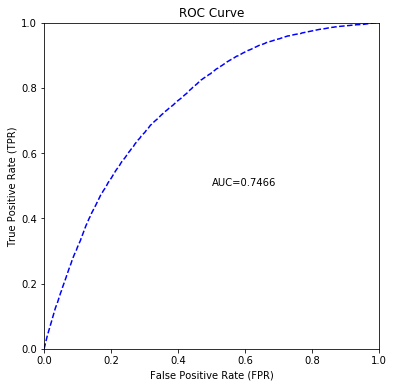

In [121]:
tmp = glm_model.model_performance(valid=True)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
tmp.plot()

# TODO: in presentation add line at y = .95

### Business Metrics

In [134]:
glm_res = validate.cbind(glm_model.predict(validate))
glm_res = glm_res[['issue_d_year', 'loan_status', 'loan_amnt', 'total_pymnt', 'p1']]
glm_res['pred1'] = glm_res['p1'] > glm_model.find_threshold_by_max_metric('accuracy')
glm_res['pred1'] = glm_res['p1'] > .79 # TODO: ROI if 5% we can refuse by mistake
glm_res['pred2'] = glm_res['p1'] > glm_sel_thr
glm_res = glm_res[glm_res['loan_status'] != 'Current']

glm_res['loan_amnt1'] = glm_res['loan_amnt'] * (1.0 - glm_res['pred1'])
glm_res['loan_amnt2'] = glm_res['loan_amnt'] * (1.0 - glm_res['pred2'])

glm_res['total_pymnt1'] = glm_res['total_pymnt'] * (1.0 - glm_res['pred1'])
glm_res['total_pymnt2'] = glm_res['total_pymnt'] * (1.0 - glm_res['pred2'])

tmp = glm_res.group_by('issue_d_year') \
    .sum('loan_amnt2') \
    .sum('loan_amnt1') \
    .sum('loan_amnt') \
    .sum('total_pymnt2') \
    .sum('total_pymnt1') \
    .sum('total_pymnt') \
    .get_frame()

tmp['REVENUE (in mln)'] = (tmp['sum_total_pymnt']  / 1e6).round(2)
tmp['PROFIT (in mln)'] = ((tmp['sum_total_pymnt'] - tmp['sum_loan_amnt']) / 1e6).round(2)
tmp['ROI (%)'] = ((tmp['sum_total_pymnt'] / tmp['sum_loan_amnt'] - 1.0) * 100.0).round(2)

tmp['REVENUE1 (in mln)'] = (tmp['sum_total_pymnt1']  / 1e6).round(2)
tmp['PROFIT1 (in mln)'] = ((tmp['sum_total_pymnt1'] - tmp['sum_loan_amnt1']) / 1e6).round(2)
tmp['ROI1 (%)'] = ((tmp['sum_total_pymnt1'] / tmp['sum_loan_amnt1'] - 1.0) * 100.0).round(2)

tmp['REVENUE2 (in mln)'] = (tmp['sum_total_pymnt2']  / 1e6).round(2)
tmp['PROFIT2 (in mln)'] = ((tmp['sum_total_pymnt2'] - tmp['sum_loan_amnt2']) / 1e6).round(2)
tmp['ROI2 (%)'] = ((tmp['sum_total_pymnt2'] / tmp['sum_loan_amnt2'] - 1.0) * 100.0).round(2)

tmp[['issue_d_year', 
     'REVENUE (in mln)', 'PROFIT (in mln)', 'ROI (%)',
     'REVENUE1 (in mln)', 'PROFIT1 (in mln)', 'ROI1 (%)',
     'REVENUE2 (in mln)', 'PROFIT2 (in mln)', 'ROI2 (%)'
    ]]    

glm prediction progress: |████████████████████████████████████████████████| 100%


issue_d_year,REVENUE (in mln),PROFIT (in mln),ROI (%),REVENUE1 (in mln),PROFIT1 (in mln),ROI1 (%),REVENUE2 (in mln),PROFIT2 (in mln),ROI2 (%)
2007,0.89,-0.08,-8.09,0.89,-0.08,-8.09,0.63,-0.06,-9.32
2008,3.82,-0.29,-6.96,3.79,-0.29,-7.01,1.06,-0.19,-15.21
2009,10.79,0.87,8.8,10.32,0.83,8.8,0.74,0.05,7.95
2010,27.75,1.77,6.82,27.31,1.76,6.87,6.27,-0.05,-0.74
2011,49.26,3.08,6.67,48.07,3.2,7.14,9.64,0.64,7.1
2012,139.58,10.73,8.33,116.61,9.11,8.47,15.71,0.93,6.26
2013,213.05,0.91,0.43,168.82,2.26,1.35,22.15,0.96,4.51
2014,189.93,-21.05,-9.98,183.14,-19.57,-9.65,53.08,-2.19,-3.97
2015,74.52,-17.4,-18.93,72.47,-16.23,-18.29,27.09,-2.43,-8.23


### Distributed Random Forest

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

#### Tune Forest Parameters

In [142]:
from h2o.grid import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator
import numpy as np

h2o.remove('drf_grid')
ntrees_grid = [120, 150]
depth_grid = [20, 30, 40]

drf_grid = H2OGridSearch(
        model=H2ORandomForestEstimator(distribution='multinomial'),
        hyper_params={'ntrees': ntrees_grid, 
                      'max_depth': depth_grid},
        grid_id='drf_grid'
    )

drf_grid.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = weight)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [144]:
# get the AUC on validation set:
pd_auc = pd.DataFrame(list(drf_grid.auc(valid=True).items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values

pd_auc['ntrees'] = np.array([drf_grid.get_hyperparams_dict(model, display=False)['ntrees'] for model in model_ids])
pd_auc['max_depth'] = np.array([drf_grid.get_hyperparams_dict(model, display=False)['max_depth'] for model in model_ids])

pd_auc = pd_auc.sort_values('AUC', ascending=False)

# select best model hyperparameters and remove the grid
drf_best_model_depth = pd_auc['max_depth'].values[0]
drf_best_model_ntrees = pd_auc['ntrees'].values[0]
drf_best_model_AUC = pd_auc['AUC'].values[0]

pd_auc.head(10)

,Model_ID,AUC,ntrees,max_depth
0,drf_grid2_model_6,0.751718,100,15
11,drf_grid2_model_8,0.751448,80,15
15,drf_grid2_model_12,0.751344,100,17
4,drf_grid2_model_9,0.750464,80,17
7,drf_grid2_model_13,0.749643,100,19
5,drf_grid2_model_10,0.749088,80,19
1,drf_grid2_model_15,0.748506,120,20
16,drf_grid2_model_18,0.748389,150,20
12,drf_grid2_model_7,0.748097,120,13
6,drf_grid2_model_1,0.741379,100,10


#### Final model

- with 10 fold cross-validation for bulidng ensemble

In [210]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

drf_model = H2ORandomForestEstimator(distribution="multinomial", 
                                    ntrees=int(drf_best_model_ntrees), 
                                    max_depth=int(drf_best_model_depth), 
                                    nfolds = 0,
                                    seed = 2014,
                                    keep_cross_validation_predictions=True
                                    )

drf_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column=weight)

drf Model Build progress: |███████████████████████████████████████████████| 100%


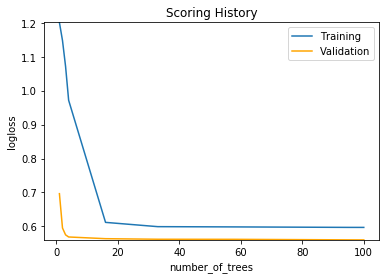

In [211]:
drf_model.plot()

In [212]:
thr_grid = [i / 100 for i in range(33, 70)]
thr_grid_recall_train = pd.DataFrame(drf_model.recall(thr_grid, train=True), columns=['thr', 'RECALL'])
thr_grid_fpr_train = pd.DataFrame(drf_model.fpr(thr_grid, train=True), columns=['thr', 'FPR'])
thr_grid_recall_valid = pd.DataFrame(drf_model.recall(thr_grid, valid=True), columns=['thr', 'RECALL (valid)'])
thr_grid_fpr_valid = pd.DataFrame(drf_model.fpr(thr_grid, valid=True), columns=['thr', 'FPR (valid)'])

thr_grid = thr_grid_recall_train.merge(thr_grid_fpr_train).merge(thr_grid_recall_valid).merge(thr_grid_fpr_valid)
thr_grid['> min_recall'] = thr_grid['RECALL'] >= usr_min_recall
drf_thr_grid = thr_grid
drf_sel_thr = thr_grid.loc[thr_grid['> min_recall'], 'thr'].max()

drf_thr_grid

Could not find exact threshold 0.33; using closest threshold found 0.3309039429717091.
Could not find exact threshold 0.34; using closest threshold found 0.3398009412973838.
Could not find exact threshold 0.35; using closest threshold found 0.35023040774160685.
Could not find exact threshold 0.36; using closest threshold found 0.35954389105210377.
Could not find exact threshold 0.37; using closest threshold found 0.3694456935993558.
Could not find exact threshold 0.38; using closest threshold found 0.3808257966288078.
Could not find exact threshold 0.39; using closest threshold found 0.38981387511546495.
Could not find exact threshold 0.4; using closest threshold found 0.3995104520315735.
Could not find exact threshold 0.41; using closest threshold found 0.409626313252127.
Could not find exact threshold 0.42; using closest threshold found 0.41956034915597745.
Could not find exact threshold 0.43; using closest threshold found 0.43045163736573844.
Could not find exact threshold 0.44; usi

Could not find exact threshold 0.53; using closest threshold found 0.5305857850923195.
Could not find exact threshold 0.54; using closest threshold found 0.540725180650127.
Could not find exact threshold 0.55; using closest threshold found 0.5497638594380809.
Could not find exact threshold 0.56; using closest threshold found 0.5599615229390698.
Could not find exact threshold 0.57; using closest threshold found 0.5699235297226205.
Could not find exact threshold 0.58; using closest threshold found 0.5795222365806132.
Could not find exact threshold 0.59; using closest threshold found 0.5901351441620986.
Could not find exact threshold 0.6; using closest threshold found 0.5998246315459738.
Could not find exact threshold 0.61; using closest threshold found 0.6100217475754249.
Could not find exact threshold 0.62; using closest threshold found 0.6198955521952735.
Could not find exact threshold 0.63; using closest threshold found 0.6306505878708925.
Could not find exact threshold 0.64; using cl

,thr,RECALL,FPR,RECALL (valid),FPR (valid),> min_recall
0,0.33,0.910484,0.601501,0.917543,0.600140,True
1,0.34,0.903044,0.586955,0.909399,0.584123,True
2,0.35,0.894888,0.570369,0.899389,0.568587,False
3,0.36,0.887004,0.556574,0.889888,0.554552,False
4,0.37,0.877449,0.541435,0.881235,0.538638,False
5,0.38,0.866118,0.524710,0.871819,0.524573,False
6,0.39,0.857757,0.511966,0.862742,0.510666,False
7,0.40,0.848372,0.498188,0.852901,0.496345,False
8,0.41,0.837281,0.483712,0.841194,0.483207,False
9,0.42,0.826838,0.469520,0.830081,0.467196,False


In [213]:
drf_model.model_performance(valid=True).confusion_matrix(thresholds=[drf_sel_thr, .69])

Could not find exact threshold 0.34; using closest threshold found 0.3397133480899391.
Could not find exact threshold 0.69; using closest threshold found 0.6900827352561385.
Confusion Matrix (Act/Pred) @ threshold = 0.3397133480899391: 


,0,1,Error,Rate
0,68154.0,95726.0,0.5841,(95726.0/163880.0)
1,1068.0,10720.0,0.0906,(1068.0/11788.0)
Total,69222.0,106446.0,0.551,(96794.0/175668.0)


Confusion Matrix (Act/Pred) @ threshold = 0.6900827352561385: 


,0,1,Error,Rate
0,155699.0,8181.0,0.0499,(8181.0/163880.0)
1,9572.0,2216.0,0.812,(9572.0/11788.0)
Total,165271.0,10397.0,0.1011,(17753.0/175668.0)


[, ]

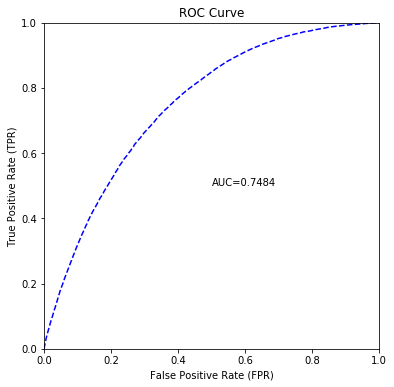

In [214]:
tmp = drf_model.model_performance(test)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
tmp.plot()

# TODO: in presentation add line at y = .95

### Business Metrics

In [215]:
drf_res = validate.cbind(drf_model.predict(validate))
drf_res = drf_res[['issue_d_year', 'loan_status', 'loan_amnt', 'total_pymnt', 'p1']]
drf_res['pred1'] = drf_res['p1'] > drf_model.find_threshold_by_max_metric('accuracy')
drf_res['pred1'] = drf_res['p1'] > .69
drf_res['pred2'] = drf_res['p1'] > drf_sel_thr
drf_res = drf_res[drf_res['loan_status'] != 'Current']

drf_res['loan_amnt1'] = drf_res['loan_amnt'] * (1.0 - drf_res['pred1'])
drf_res['loan_amnt2'] = drf_res['loan_amnt'] * (1.0 - drf_res['pred2'])

drf_res['total_pymnt1'] = drf_res['total_pymnt'] * (1.0 - drf_res['pred1'])
drf_res['total_pymnt2'] = drf_res['total_pymnt'] * (1.0 - drf_res['pred2'])

tmp = drf_res.group_by('issue_d_year') \
    .sum('loan_amnt2') \
    .sum('loan_amnt1') \
    .sum('loan_amnt') \
    .sum('total_pymnt2') \
    .sum('total_pymnt1') \
    .sum('total_pymnt') \
    .get_frame()

tmp['REVENUE (in mln)'] = (tmp['sum_total_pymnt']  / 1e6).round(2)
tmp['PROFIT (in mln)'] = ((tmp['sum_total_pymnt'] - tmp['sum_loan_amnt']) / 1e6).round(2)
tmp['ROI (%)'] = ((tmp['sum_total_pymnt'] / tmp['sum_loan_amnt'] - 1.0) * 100.0).round(2)

tmp['REVENUE1 (in mln)'] = (tmp['sum_total_pymnt1']  / 1e6).round(2)
tmp['PROFIT1 (in mln)'] = ((tmp['sum_total_pymnt1'] - tmp['sum_loan_amnt1']) / 1e6).round(2)
tmp['ROI1 (%)'] = ((tmp['sum_total_pymnt1'] / tmp['sum_loan_amnt1'] - 1.0) * 100.0).round(2)

tmp['REVENUE2 (in mln)'] = (tmp['sum_total_pymnt2']  / 1e6).round(2)
tmp['PROFIT2 (in mln)'] = ((tmp['sum_total_pymnt2'] - tmp['sum_loan_amnt2']) / 1e6).round(2)
tmp['ROI2 (%)'] = ((tmp['sum_total_pymnt2'] / tmp['sum_loan_amnt2'] - 1.0) * 100.0).round(2)

tmp[['issue_d_year', 
     'REVENUE (in mln)', 'PROFIT (in mln)', 'ROI (%)',
     'REVENUE1 (in mln)', 'PROFIT1 (in mln)', 'ROI1 (%)',
     'REVENUE2 (in mln)', 'PROFIT2 (in mln)', 'ROI2 (%)'
    ]]

#TODO: line plot for ROI's   

drf prediction progress: |████████████████████████████████████████████████| 100%


issue_d_year,REVENUE (in mln),PROFIT (in mln),ROI (%),REVENUE1 (in mln),PROFIT1 (in mln),ROI1 (%),REVENUE2 (in mln),PROFIT2 (in mln),ROI2 (%)
2007,0.89,-0.08,-8.09,0.8,-0.03,-3.81,0.08,0,6.51
2008,3.82,-0.29,-6.96,3.37,-0.25,-6.95,0.3,0,1.61
2009,10.79,0.87,8.8,9.3,0.77,9.09,0.57,0.05,9.92
2010,27.75,1.77,6.82,23.36,1.37,6.21,3.58,0,0.13
2011,49.26,3.08,6.67,41.74,2.95,7.59,8.1,0.55,7.23
2012,139.58,10.73,8.33,115.87,9.52,8.96,18.29,1.13,6.58
2013,213.05,0.91,0.43,172.67,3.45,2.04,27.38,1.15,4.39
2014,189.93,-21.05,-9.98,180.15,-18.87,-9.48,51.91,-1.36,-2.54
2015,74.52,-17.4,-18.93,71.44,-15.98,-18.28,29.89,-3.07,-9.32


### Stacked Ensemble

TODO: add the article about consitent learning using ensembles  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

In [65]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

ens_model = H2OStackedEnsembleEstimator(base_models=[drf_model, glm_model])

ens_model.train(predictors, response, training_frame=train)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [66]:
thr_grid = [i / 100 for i in range(1, 10)]
thr_grid_recall_train = pd.DataFrame(ens_model.recall(thr_grid, train=True), columns=['thr', 'RECALL'])
thr_grid_fpr_train = pd.DataFrame(ens_model.fpr(thr_grid, train=True), columns=['thr', 'FPR'])
thr_grid_recall_valid = pd.DataFrame(ens_model.model_performance(validate).recall(thr_grid), 
                                     columns=['thr', 'RECALL (valid)'])
thr_grid_fpr_valid = pd.DataFrame(ens_model.model_performance(validate).fpr(thr_grid), 
                                  columns=['thr', 'FPR (valid)'])

thr_grid = thr_grid_recall_train.merge(thr_grid_fpr_train).merge(thr_grid_recall_valid).merge(thr_grid_fpr_valid)
thr_grid['> min_recall'] = thr_grid['RECALL'] >= usr_min_recall
ens_thr_grid = thr_grid
ens_sel_thr = thr_grid.loc[thr_grid['> min_recall'], 'thr'].max()

ens_thr_grid

Could not find exact threshold 0.01; using closest threshold found 0.009884723978702457.
Could not find exact threshold 0.02; using closest threshold found 0.019907233088456322.
Could not find exact threshold 0.03; using closest threshold found 0.029979134241519143.
Could not find exact threshold 0.04; using closest threshold found 0.04006450661383323.
Could not find exact threshold 0.05; using closest threshold found 0.05013523977468975.
Could not find exact threshold 0.06; using closest threshold found 0.059815503161473174.
Could not find exact threshold 0.07; using closest threshold found 0.0699057176815873.
Could not find exact threshold 0.08; using closest threshold found 0.0799811100279259.
Could not find exact threshold 0.09; using closest threshold found 0.08988817342606739.
Could not find exact threshold 0.01; using closest threshold found 0.009884723978702457.
Could not find exact threshold 0.02; using closest threshold found 0.019907233088456322.
Could not find exact thresho

,thr,RECALL,FPR,RECALL (valid),FPR (valid),> min_recall
0,0.01,1.000000,1.000000,1.000000,1.000000,True
1,0.02,0.973484,0.828171,0.972604,0.829093,True
2,0.03,0.924164,0.681084,0.919593,0.681232,True
3,0.04,0.859526,0.563449,0.860051,0.566401,False
4,0.05,0.787808,0.472606,0.784987,0.473329,False
5,0.06,0.746622,0.430532,0.741137,0.429871,False
6,0.07,0.710814,0.390403,0.703562,0.391454,False
7,0.08,0.664692,0.344716,0.656573,0.346251,False
8,0.09,0.605909,0.295918,0.596862,0.297894,False


In [67]:
ens_model.model_performance(validate).confusion_matrix(thresholds=ens_sel_thr, metrics='accuracy')

Could not find exact threshold 0.03; using closest threshold found 0.030019319356088193.
Confusion Matrix (Act/Pred) @ threshold = 0.030019319356088193: 


,0,1,Error,Rate
0,52241.0,111643.0,0.6812,(111643.0/163884.0)
1,948.0,10842.0,0.0804,(948.0/11790.0)
Total,53189.0,122485.0,0.6409,(112591.0/175674.0)


Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.2544249612644192: 


,0,1,Error,Rate
0,163882.0,2.0,0.0,(2.0/163884.0)
1,11788.0,2.0,0.9998,(11788.0/11790.0)
Total,175670.0,4.0,0.0671,(11790.0/175674.0)


[, ]

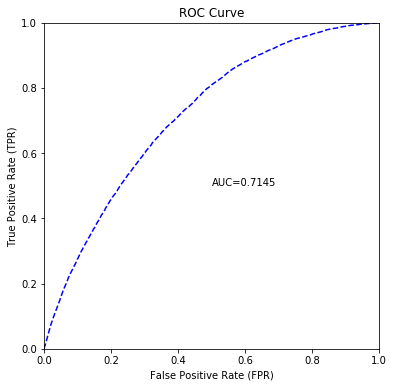

In [68]:
tmp = ens_model.model_performance(validate)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
tmp.plot()

# TODO: in presentation add line at y = .95

### Business Metrics

In [71]:
ens_res = validate.cbind(ens_model.predict(validate))
ens_res = ens_res[['issue_d_year', 'loan_status', 'loan_amnt', 'total_pymnt', 'p1']]
ens_res['pred1'] = ens_res['p1'] > ens_model.find_threshold_by_max_metric('f2')
ens_res['pred2'] = ens_res['p1'] > ens_sel_thr
ens_res = ens_res[ens_res['loan_status'] != 'Current']

ens_res['loan_amnt1'] = ens_res['loan_amnt'] * (1.0 - ens_res['pred1'])
ens_res['loan_amnt2'] = ens_res['loan_amnt'] * (1.0 - ens_res['pred2'])

ens_res['total_pymnt1'] = ens_res['total_pymnt'] * (1.0 - ens_res['pred1'])
ens_res['total_pymnt2'] = ens_res['total_pymnt'] * (1.0 - ens_res['pred2'])

tmp = ens_res.group_by('issue_d_year') \
    .sum('loan_amnt2') \
    .sum('loan_amnt1') \
    .sum('loan_amnt') \
    .sum('total_pymnt2') \
    .sum('total_pymnt1') \
    .sum('total_pymnt') \
    .get_frame()

tmp['REVENUE (in mln)'] = (tmp['sum_total_pymnt']  / 1e6).round(2)
tmp['PROFIT (in mln)'] = ((tmp['sum_total_pymnt'] - tmp['sum_loan_amnt']) / 1e6).round(2)
tmp['ROI (%)'] = ((tmp['sum_total_pymnt'] / tmp['sum_loan_amnt'] - 1.0) * 100.0).round(2)

tmp['REVENUE1 (in mln)'] = (tmp['sum_total_pymnt1']  / 1e6).round(2)
tmp['PROFIT1 (in mln)'] = ((tmp['sum_total_pymnt1'] - tmp['sum_loan_amnt1']) / 1e6).round(2)
tmp['ROI1 (%)'] = ((tmp['sum_total_pymnt1'] / tmp['sum_loan_amnt1'] - 1.0) * 100.0).round(2)

tmp['REVENUE2 (in mln)'] = (tmp['sum_total_pymnt2']  / 1e6).round(2)
tmp['PROFIT2 (in mln)'] = ((tmp['sum_total_pymnt2'] - tmp['sum_loan_amnt2']) / 1e6).round(2)
tmp['ROI2 (%)'] = ((tmp['sum_total_pymnt2'] / tmp['sum_loan_amnt2'] - 1.0) * 100.0).round(2)

tmp[['issue_d_year', 
     'REVENUE (in mln)', 'PROFIT (in mln)', 'ROI (%)',
     'REVENUE1 (in mln)', 'PROFIT1 (in mln)', 'ROI1 (%)',
     'REVENUE2 (in mln)', 'PROFIT2 (in mln)', 'ROI2 (%)'
    ]]

 

stackedensemble prediction progress: |████████████████████████████████████| 100%


issue_d_year,REVENUE (in mln),PROFIT (in mln),ROI (%),REVENUE1 (in mln),PROFIT1 (in mln),ROI1 (%),REVENUE2 (in mln),PROFIT2 (in mln),ROI2 (%)
2007,1.04,-0.07,-6.3,0.73,0,-0.65,0.31,0.04,12.56
2008,3.96,-0.29,-6.78,2.65,-0.17,-6.06,0.4,-0.04,-9.48
2009,10.34,0.79,8.25,6.23,0.48,8.3,1.81,0.14,8.52
2010,28.64,1.58,5.85,17.3,0.65,3.93,7.16,-0.1,-1.35
2011,47.4,2.84,6.38,29.27,2.09,7.7,13.98,0.91,6.99
2012,141.27,10.88,8.34,67.21,5.39,8.71,28.88,2.07,7.74
2013,214.15,1.81,0.85,103.86,3.76,3.76,38.83,1.44,3.85
2014,189.11,-21.43,-10.18,99.01,-5.92,-5.64,37.07,-0.98,-2.56
2015,71.12,-17.86,-20.07,38.95,-5.67,-12.71,17.64,-1.61,-8.36


In [77]:
tmp[['PROFIT (in mln)', 'PROFIT1 (in mln)', 'PROFIT2 (in mln)']].as_data_frame().apply(lambda x: np.sum(x), axis=0)   

PROFIT (in mln)    -21.75
PROFIT1 (in mln)     0.61
PROFIT2 (in mln)     1.87
dtype: float64

In [ ]:
model_0_m_avg_per_conv = (train[['m']] * train[['n']]).sum() / train[train['y']=='1', 'n'].sum()
print('Average revenue per conversion: {:.2f}$'.format(model_0_m_avg_per_conv))

glm_model_pred = glm_model.predict(validate)
glm_model_pred
validate['pred_revenue'] = model_0_m_avg_per_conv * glm_model_pred['p1']

pp = glm_model_pred['p1'].sum() / glm_model_pred['p1'].nrows
validate['pred_revenue_uw'] = model_0_m_avg_per_conv * (glm_model_pred['p1'] / pp * .0138)

# evaluate target metrics:

frame = validate
model_1_err1 = ((frame['pred_revenue'] - frame['rpc']) * (frame['pred_revenue'] - frame['rpc']) * frame['n']).sum() / frame['n'].sum()
model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

In [ ]:
# add offsets to df's
validate['offset'] = model_0_m_avg_per_conv * (glm_model.predict(validate)['p1'] / pp * .0138)
train['offset'] = model_0_m_avg_per_conv * (glm_model.predict(train)['p1'] / pp * .0138)
test['offset'] = model_0_m_avg_per_conv * (glm_model.predict(test)['p1'] / pp * .0138)

In [ ]:
from pyspark.sql.functions import col, log, sum
pdf = sdf \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', (col('Revenue') / col('Clicks'))) \
        .select('Clicks', 'Conversions' ,'log_prob_of_conv', 'log_of_revenue', 'rpc') \
        .sample(True, .01).toPandas()

In [ ]:
pdf.corr()

In [ ]:
pdf.describe()

In [ ]:
pdf['rpc'].hist(bins=40)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(pdf, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

## Data preparation

TODO's:

 - explode and save spark data frame &#9989;
 - baseline model
 - maximum and minimum attainable accuracy
 - add weighting of classes as a parameter to be tunned
 - cleaning

#### Class balancing

In [ ]:
tmp_0 = sdf_exp.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage before weighting: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

In [ ]:
# class weights
N = tmp_0 + tmp_1
w_0 = N * .5 / tmp_0
w_1 = N * .5 / tmp_1

In [ ]:
from pyspark.sql.functions import when

sdf_exp_w = sdf_exp \
            .withColumn('n_orig', col('n')) \
            .withColumn('n', when(col('y') == 1, col('n') * w_1).otherwise(col('n') * w_0))
    
tmp_0 = sdf_exp_w.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp_w.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage after balancing: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

#### Maximum attainable accuracy (Move to the baseline setting)

$$ \frac{1}{C} \sum_{n = 1}^N c_n * \mathrm{max}_y\{c(y) \} $$

where $c(y)$ is a number of click events that ended with state $y$.

In [ ]:
from pyspark.sql.functions import when

tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', when((col('Clicks') - col('Conversions')) > col('Conversions'), 
                              col('Clicks') - col('Conversions')).otherwise(col('Conversions'))) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Minimum possible error: {:2.2f}%'.format(100 - tmp[0].score / tmp[0].Clicks * 100) )

#### Minimum attainable accuracy

- when we always assume lack of conversion

In [ ]:
tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', col('Clicks') - col('Conversions')) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Class majority error: {:2.2f}%'.format(100 - tmp[0].score / tmp[0].Clicks * 100) )

### Average probability of conversion over time

In [ ]:
tmp = sdf \
        .groupBy('Date') \
        .agg(*[sum(col('Conversions')).alias('Conversions'), 
           sum(col('Clicks')).alias('Clicks'), 
           sum(col('Revenue')).alias('Revenue')]) \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', log(col('Revenue') / col('Clicks'))) \
        .orderBy(col('Date').asc()) \
        .toPandas()

In [ ]:
from plotnine import ggplot, geom_line, aes, theme_bw
import plotnine
plotnine.options.figure_size = (11, 4)


ggplot(aes(x='Date', y='prob_of_conv'), data=tmp) + geom_line() + theme_bw()

### Remove rare keywords using Chi-Square test of independence

In [ ]:
from pyspark.sql.functions import pow

tmp = sdf_exp_w \
        .select('Keyword_ID', 'y', 'n') \
        .groupBy('Keyword_ID', 'y') \
        .agg(sum(col('n')).alias('n')) \
        .groupBy('Keyword_ID') \
        .pivot('y', [0, 1]).sum('n') \
        .withColumn('1', when(col('1').isNull(), 0.0).otherwise(col('1'))) \
        .withColumn('n', col('0') + col('1')) \
        .withColumn('X', pow(col('0') - col('n') * .5, 2) / (col('n') * .5) * 2.0) \
        .orderBy(col('n').desc()) \
        .persist()
        
tmp.show(5)
tmp.count()

In [ ]:
tmp.select('X').sample(fraction=.1, withReplacement=False, seed=2014).toPandas()['X'] \
    .hist(bins=30, figsize=(13, 5), range=[0, 200])


https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_χ2_values_vs_p-values

In [ ]:
# very at least 100 searches and Pval<.01

print(tmp.count())
print(tmp.filter(col('X') > 3.84).count())
print(tmp.filter((col('n') > 100)).count())
print(tmp.filter((col('X') > 6.63) & (col('n') > 100)).count())

In [ ]:
# create sdf with pruned keyword variable

from pyspark.sql.functions import lit
sdf_rm_keywords = tmp.filter((col('X') > 6.63) & (col('n') > 100)).select('Keyword_ID').withColumn("valid", lit(1)).persist()
sdf_rm_keywords.count()

In [ ]:
sdf_exp_w_r = sdf_exp_w.alias('A') \
        .join(sdf_rm_keywords.alias('B'), col('A.Keyword_ID') == col('B.Keyword_ID'), how='left') \
        .withColumn('valid', when(col('valid').isNull(), 0).otherwise(col('valid'))) \
        .drop(col('B.Keyword_ID')) \
        .withColumn('Keyword_ID_r', when(col('valid') == 1, col('Keyword_ID')).otherwise(0)) \
        .drop('valid') \
        .persist()
        
sdf_exp_w_r.count()

### Remove rare groups using Chi-Square test of independence

In [ ]:
from pyspark.sql.functions import pow

cat_var = 'Ad_group_ID'
tmp = sdf_exp_w \
        .select(cat_var, 'y', 'n') \
        .groupBy(cat_var, 'y') \
        .agg(sum(col('n')).alias('n')) \
        .groupBy(cat_var) \
        .pivot('y', [0, 1]).sum('n') \
        .withColumn('1', when(col('1').isNull(), 0.0).otherwise(col('1'))) \
        .withColumn('n', col('0') + col('1')) \
        .withColumn('X', pow(col('0') - col('n') * .5, 2) / (col('n') * .5) * 2.0) \
        .orderBy(col('n').desc()) \
        .persist()
        
tmp.show(5)
tmp.count()

In [ ]:
tmp.select('X').sample(fraction=.1, withReplacement=False, seed=2014).toPandas()['X'] \
    .hist(bins=30, figsize=(13, 5), range=[0, 200])


https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_χ2_values_vs_p-values

In [ ]:
# very at least 100 searches and Pval<.01

print(tmp.count())
print(tmp.filter(col('X') > 3.84).count())
print(tmp.filter((col('n') > 100)).count())
print(tmp.filter((col('X') > 6.63) & (col('n') > 100)).count())

In [ ]:
# create sdf with pruned keyword variable

from pyspark.sql.functions import lit
sdf_rm_keywords = tmp.filter((col('X') > 6.63) & (col('n') > 100)).select(cat_var).withColumn("valid", lit(1)).persist()
sdf_rm_keywords.count()

In [ ]:
sdf_exp_w_r = sdf_exp_w_r.alias('A') \
        .join(sdf_rm_keywords.alias('B'), col('A.' + cat_var) == col('B.' + cat_var), how='left') \
        .withColumn('valid', when(col('valid').isNull(), 0).otherwise(col('valid'))) \
        .drop(col('B.' + cat_var)) \
        .withColumn(cat_var + '_r', when(col('valid') == 1, col(cat_var)).otherwise(0)) \
        .persist()
        
sdf_exp_w_r.count()

### Clean the data

In [ ]:
# remove 0.0$ conversions
m_n_0 = sdf_exp_w_r.filter((col('y') > 0) & (col('m') == 0)).count()
m_n = sdf_exp_w_r.filter((col('y') > 0)).count()

print('Removing 0.0$ conversions: {} ({:2.2f}%)'.format(m_n_0, m_n_0 / m_n * 100))

ff = ((col('y') > 0) & (col('m') > 0)) | (col('y') == 0)
sdf_exp_w_r = sdf_exp_w_r.filter(ff).persist()
sdf_exp_w_r.count()

### Import data to h2o DataFrame

In [ ]:
import h2o
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

In [ ]:
h2o.remove_all()
df = hc.as_h2o_frame(sdf_exp_w_r, framename='sdf_exp_w_r')

In [ ]:
df['Keyword_ID'] = df['Keyword_ID'].asfactor()
df['Keyword_ID_r'] = df['Keyword_ID_r'].asfactor()
df['Ad_group_ID'] = df['Ad_group_ID'].asfactor()
df['Ad_group_ID_r'] = df['Ad_group_ID_r'].asfactor()
df['Campaign_ID'] = df['Campaign_ID'].asfactor()
df['Match_type_ID'] = df['Match_type_ID'].asfactor()
df['Device_ID'] = df['Device_ID'].asfactor()

df['Month'] = df['Date'].month().asfactor()
df['Week'] = df['Date'].week().asfactor()
df['Day'] = df['Date'].dayOfWeek().asfactor()

df['rpc'] = df['rpc'].asnumeric()

df['y'] = df['y'].asfactor()

In [ ]:
df.names

### Detect outliers of m - on logarithmic scale (average Revenue per conversion)

In [ ]:
tmp = df[['m', 'y']].as_data_frame()
len(tmp)
tmp.head()

In [ ]:
# take log where it is positive, else we put NaN to capture possible errors when using wrong values
tmp.loc[tmp['y'] > 0, 'log_m'] = np.log(tmp[tmp['y'] > 0]['m'])
tmp.describe()

In [ ]:
# remove outliers using EllipticEnvelope
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope()
ee.fit(tmp[tmp['y'] > 0][['log_m']])
tmp.loc[tmp['y'] > 0, 'outlier'] = ee.predict(tmp[tmp['y'] > 0][['log_m']])
tmp.describe()

In [ ]:
tmp[tmp['y'] > 0][['log_m', 'outlier']].groupby('outlier').hist()

In [ ]:
tmp.loc[np.isnan(tmp['outlier']), 'outlier'] = 0
tmp.describe()

In [ ]:
# merge back with h2o df:
df_out_m = h2o.H2OFrame(tmp[['outlier']])

In [ ]:
df = df.cbind(df_out_m)
df.names

### Test, Train, Validate

Few comments about splitting the dataset (date and Keyword are the key)

In [ ]:
train, validate, test = df[df['outlier'] > -1, :].split_frame([.8, .1], seed=2014)

predictors = ['Keyword_ID_r', 'Ad_group_ID_r', 'Campaign_ID', 
              'Account_ID', 'Match_type_ID', 'Device_ID', 'Month', 'Day', 'Week']
response = 'y'
weights_col = 'n'

### Model building process

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- majority class assignment for `y`
- dataset average for `m`

Note: We evaluate model bulding progress using validation set.

In [ ]:
# trivial model predictions:

model_0_m_avg = (train[['m']] * train[['n']]).sum() / train[['n']].sum()
model_0_m_avg_uw = (train[['m']] * train[['n_orig']]).sum() / train[['n_orig']].sum()
print('Average revenue per click: {:.2f}$'.format(model_0_m_avg))
print('Average revenue per click (unweighted): {:.2f}$'.format(model_0_m_avg_uw))

validate['pred_revenue'] = model_0_m_avg
validate['pred_revenue_uw'] = model_0_m_avg_uw

# evaluate target metrics:

frame = validate
model_0_err1 = ((frame['pred_revenue'] - frame['rpc']) * (frame['pred_revenue'] - frame['rpc']) * frame['n']).sum() / frame['n'].sum()
model_0_err2 = np.sqrt(model_0_err1)

model_0_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_0_err2_uw = np.sqrt(model_0_err1_uw)

print('RMSE: {:.2f}$'.format(model_0_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_0_err2_uw))

### Model for `P[Conversion]`: Lasso Logistic regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

#### Tune lasso parameters

In [ ]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

lambda_grid = list(np.logspace(start=-7.0, stop=-3.0, num=10, base=10.0))

g = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="binomial", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id="glm_grid"
    )

g.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = weights_col)

In [ ]:
import pandas as pd
pd_auc = pd.DataFrame(list(g.auc().items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values
pd_auc['lambda'] = np.array([g.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_auc = pd_auc.sort_values('AUC', ascending=False)

pd_auc

# select best model and remove the rest
# h2o.remove_all()

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_model = H2OGeneralizedLinearEstimator(family="binomial", 
                                          lambda_=1.668101e-05, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

glm_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = 'n')

In [ ]:
glm_model.model_performance(train).confusion_matrix(metrics='accuracy', thresholds=[.5])

In [ ]:
glm_model.model_performance(validate).confusion_matrix(metrics='accuracy', thresholds=[.5])

In [ ]:
tmp = glm_model.model_performance(train)
from matplotlib import pyplot as plt
# plt.figure(figsize=(7, 7))
tmp.plot()

### Validate model:

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- class assignment for `y` according to `P[Conversion]` with tuned threshold
- dataset average for `m`

In [ ]:
model_0_m_avg_per_conv = (train[['m']] * train[['n']]).sum() / train[train['y']=='1', 'n'].sum()
print('Average revenue per conversion: {:.2f}$'.format(model_0_m_avg_per_conv))

glm_model_pred = glm_model.predict(validate)
glm_model_pred
validate['pred_revenue'] = model_0_m_avg_per_conv * glm_model_pred['p1']

pp = glm_model_pred['p1'].sum() / glm_model_pred['p1'].nrows
validate['pred_revenue_uw'] = model_0_m_avg_per_conv * (glm_model_pred['p1'] / pp * .0138)

# evaluate target metrics:

frame = validate
model_1_err1 = ((frame['pred_revenue'] - frame['rpc']) * (frame['pred_revenue'] - frame['rpc']) * frame['n']).sum() / frame['n'].sum()
model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

In [ ]:
# add offsets to df's
validate['offset'] = model_0_m_avg_per_conv * (glm_model.predict(validate)['p1'] / pp * .0138)
train['offset'] = model_0_m_avg_per_conv * (glm_model.predict(train)['p1'] / pp * .0138)
test['offset'] = model_0_m_avg_per_conv * (glm_model.predict(test)['p1'] / pp * .0138)

### Model for `E[logm]`: Lasso Linear Regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

In [ ]:
predictors = ['Keyword_ID_r', 'Ad_group_ID_r', 'Campaign_ID', 
              'Account_ID', 'Match_type_ID', 'Device_ID', 'Month', 'Day', 'Week']
response = 'rpc'
weights_col = 'n_orig'

#### Tune lasso parameters

In [ ]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

lambda_grid = list(np.logspace(start=-7.0, stop=-3.0, num=10, base=10.0))

h2o.remove('lm_grid')
g_lm = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="gaussian", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id="lm_grid"
    )

g_lm.train(predictors, response, training_frame=train_m, validation_frame=validate_m, weights_column = weights_col)

In [ ]:
import pandas as pd
pd_dev = pd.DataFrame(list(g_lm.residual_deviance(valid=True).items()), columns=['Model_ID', 'DEV'])
model_ids = pd_dev['Model_ID'].values
pd_dev['lambda'] = np.array([g_lm.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_dev = pd_dev.sort_values('DEV', ascending=True)

pd_dev

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

lm_model = H2OGeneralizedLinearEstimator(family="gaussian", 
                                          lambda_=.00001, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

lm_model.train(predictors, response, training_frame=train, validation_frame=validate, 
               weights_column = weights_col,
               offset_column='offset')

In [ ]:
print(lm_model.model_performance(train).rmse())
print(lm_model.model_performance(validate).rmse())

### Validate model:

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- class assignment for `y` according to `P[Conversion]` with tuned threshold
- `m` as `$exp(E[m|data])$`

In [ ]:
glm_model_pred = glm_model.predict(validate)
lm_model_pred = lm_model.predict(validate)

# validate['pred_revenue'] = lm_model_pred
validate['pred_revenue_uw'] = lm_model_pred

# evaluate target metrics:

frame = validate
# model_1_err1 = ((frame['pred_revenue'] - frame['m']) * (frame['pred_revenue'] - frame['m']) * frame['n']).sum() / frame['n'].sum()
# model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

# print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

In [ ]:
tmp = validate[validate['rpc'] > 0, ['rpc', 'pred_revenue_uw', 'offset']].as_data_frame()

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(tmp, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

### Use simple deep learning model:

In [ ]:
tt, _  = train.split_frame([.01], seed=2014)
tt.nrows

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

lm_model = H2OGeneralizedLinearEstimator(family="gaussian", 
                                          lambda_=1.668101e-06, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

lm_model.train(predictors, 'm', training_frame=train, validation_frame=validate, weights_column = 'n_orig')

In [ ]:
print(lm_model.rmse(train=True))
print(lm_model.rmse(valid=True))

In [ ]:
lm_model_pred = lm_model.predict(validate)

validate['pred_revenue'] = lm_model_pred
validate['pred_revenue_uw'] = lm_model_pred

# evaluate target metrics:

frame = validate
model_1_err1 = ((frame['pred_revenue'] - frame['m']) * (frame['pred_revenue'] - frame['m']) * frame['n']).sum() / frame['n'].sum()
model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['m']) * (frame['pred_revenue_uw'] - frame['m']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

### Summary

- two stage models do not really work! (unless first level is very, very accurate)
- Always use simpler model from the very beginning that will open the road to smart feature engineering
    - average rev per campaign
    - avreage rev per account etcc
- All in all sampling and weighting can make a process much faste
- Balancing is a good idea but not in two step models (too much to be done in the end)
- Workflow with Sparkling water is very robust and enables to leverage a lot of Python libraries (scikit-learn, scipy)
- deep learning is not super fast (even on fast machine) so for big datasets like this one would probably still use XGboost

